In [1]:
%pip install pydicom

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: C:\Users\riddhi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
labels = pd.read_csv("D:\\rsna-pneumonia-detection-challenge\\stage_2_train_labels.csv")

In [4]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [5]:
labels = labels.drop_duplicates("patientId")

In [6]:
ROOT_PATH = Path("D:\\rsna-pneumonia-detection-challenge\\stage_2_train_images")
SAVE_PATH = Path("D:\\rsna-pneumonia-detection-challenge\\Processed")

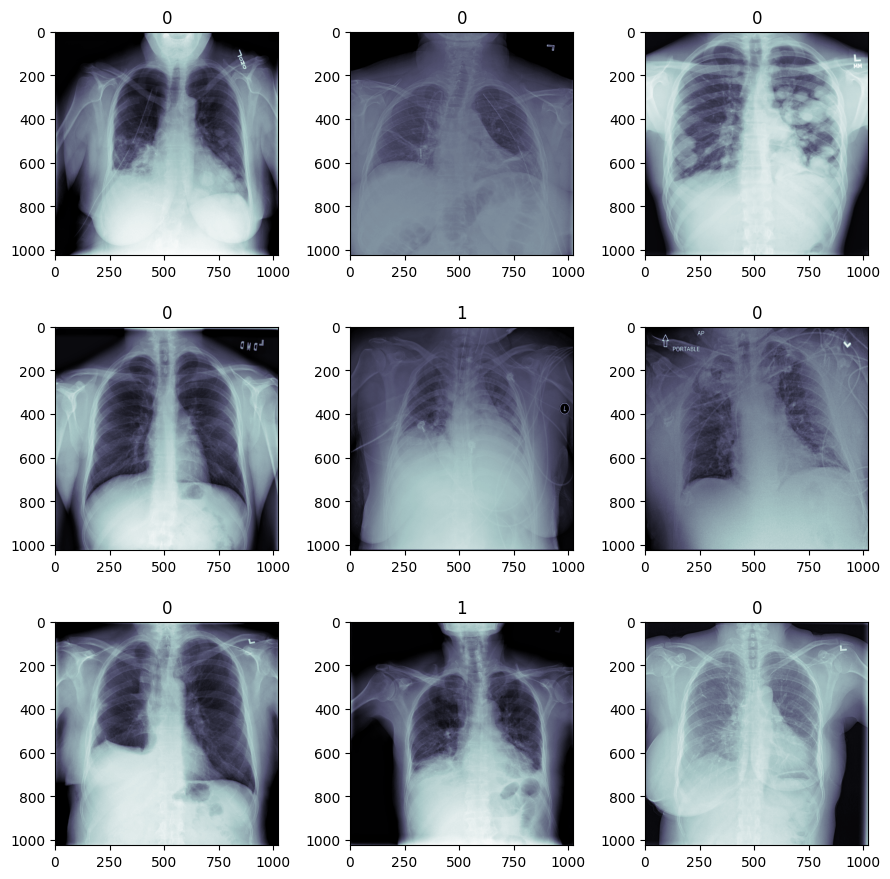

In [7]:
fig = plt.figure(figsize = (9, 9))
axis = fig.subplots(3, 3)

c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        
        try:
            dcm = pydicom.read_file(dcm_path).pixel_array
        except FileNotFoundError:
            print(f"DICOM file not found: {dcm_path}")
            continue
    
        label = labels["Target"].iloc[c]
    
        axis[i][j].imshow(dcm, cmap = "bone")
        axis[i][j].set_title(label)
        c+=1

plt.tight_layout()
plt.show()

In [11]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    
    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)
    
    label = labels.Target.iloc[c]
    
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)
    
    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [13]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)

In [14]:
mean, std

(0.4903962485384803, 0.24795070634161256)